In [36]:
import esg

In [37]:
import itertools as it

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white",
        palette="pastel",
        color_codes=True,
        rc={'figure.figsize': (12, 9) })

In [39]:
import dotenv, os

dotenv.load_dotenv()

data_path = os.path.join("..", os.environ.get("DATA_PATH"))

esg_path = os.path.join(data_path, "ESG.xlsx")
sheet_name = os.environ.get("SHEET_NAME")

own_path = os.path.join(data_path, "ownership.csv")

saliency_path = os.path.join(data_path, "saliency.csv")

In [40]:
raw = pd.read_excel(esg_path, sheet_name = sheet_name)

get_esg = esg.yearly_esg_maker(raw)

In [41]:
def pct_to_num(pct) -> float:
    """
    Convert 1% to 0.01
    """
    if type(pct) == str:
        return float(pct.replace("%", "")) / 100

    return pct

def parseownershipdata(raw):
    df = raw.dropna(axis = 0, how = 'all').dropna(axis = 1, how = 'all').dropna(axis = 0, how = 'any')

    investors = df.columns[-7:]
    for investor in investors:
        df[investor] = df[investor].apply(pct_to_num)

    return df

In [42]:
ownership = parseownershipdata(pd.read_csv(own_path))
investors = ownership.columns[-7:]

Text(0.5, 0, 'Ownership percentage')

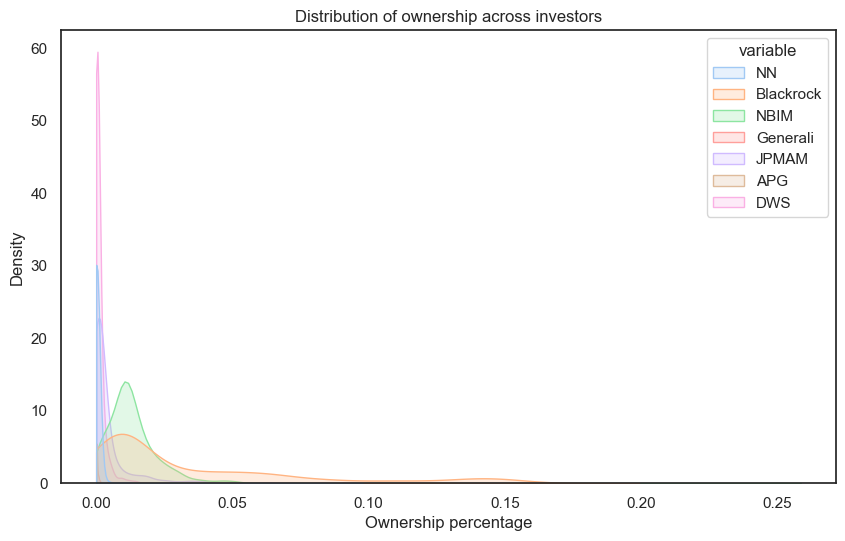

In [43]:
nonzerodf = ownership[investors].melt()
nonzerodf = nonzerodf[nonzerodf['value'] > 0]

fig, ax = plt.subplots(dpi = 100, figsize = (10, 6))
sns.kdeplot(data = nonzerodf, x = 'value', hue = 'variable', fill=True, ax = ax, clip = (0, None))
ax.set_title("Distribution of ownership across investors")
ax.set_xlabel("Ownership percentage")


In [44]:
saliency_df = pd.read_csv(saliency_path, index_col = [0, 1])

In [45]:
S = saliency_df.loc["STEWARDSHIP_POLICY", "s-index"]
companies = ownership.columns[-7:]
X = ownership[companies]
X.columns = [f"{company} ownership".lower() for company in companies]
X.index = ownership['TargetFirms']
N = X.shape[0]

In [46]:
X

,nn ownership,blackrock ownership,nbim ownership,generali ownership,jpmam ownership,apg ownership,dws ownership
TargetFirms,,,,,,,
1-800-FLOWERS.COM'A',0.00000,0.04961,0.00000,0.0,0.00027,0.0,0.00069
1STSOURCE,0.00000,0.04011,0.01231,0.0,0.00815,0.0,0.00008
3DSYSTEMS,0.00000,0.14012,0.00418,0.0,0.00000,0.0,0.00247
3IGROUP,0.00104,0.01047,0.02111,0.0,0.00405,0.0,0.00109
3PLEARNING,0.00000,0.00000,0.00000,0.0,0.00000,0.0,0.00000
...,...,...,...,...,...,...,...
ZSCALER,0.00000,0.02182,0.00482,0.0,0.01880,0.0,0.00036
ZTE'A',0.00000,0.00106,0.00000,0.0,0.00000,0.0,0.00000
ZUMIEZ,0.00000,0.11717,0.00000,0.0,0.01949,0.0,0.00118


In [47]:
def makeregressors(saliency_df, ownership, index = 's-index', report = 'STEWARDSHIP_POLICY'):
    S = saliency_df.loc[report, index]
    companies = ownership.columns[-7:]
    X = ownership[companies]
    X.columns = [f"{company} ownership".lower() for company in companies]
    X.index = ownership['TargetFirms']
    N = X.shape[0]

    for company in S.index:
        column_name = f"{company} {report.lower()}"
        X[f"{column_name} interaction"] = X[f"{company} ownership"] * S[company] 
    
    X = sm.add_constant(X, prepend = False, has_constant='add')

    return X

In [48]:
X = makeregressors(saliency_df, ownership)

/var/folders/68/f6hr2xg16v980_3qg7t2l25r0000gn/T/ipykernel_10855/1421384376.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{column_name} interaction"] = X[f"{company} ownership"] * S[company]


In [61]:
y = get_esg(2020).loc[X.index]['ESG Combined Score'] / 100

In [63]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ESG Combined Score   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     47.38
Date:                Fri, 19 Nov 2021   Prob (F-statistic):           3.81e-63
Time:                        15:50:42   Log-Likelihood:                 755.48
No. Observations:                2326   AIC:                            -1495.
Df Residuals:                    2318   BIC:                            -1449.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
nn ownership                                 1.9182      1.728      1.110      0.267      -1.471       5.307
blackrock ownership                         -0.4483      0.097     -4.622      0.000      -0.639      -0.258
nbim ownership                               5.2937      0.320     16.540      0.000       4.666       5.921
generali ownership                         247.2867     81.996      3.016      0.003      86.493     408.080
jpmam ownership                              0.6598      0.552      1.195      0.232      -0.423       1.742
apg ownership                                1.2777      3.793      0.337      0.736      -6.161       8.716
dws ownership                                3.6421      1.205      3.024      0.003       1.280       6.004
blackrock stewardship_policy interaction    -0.0079      0.002     -4.622      0.000      -0.011      -0.005
dws stewardship_policy interaction           0.0202      0.007      3.024      0.003       0.007       0.033
generali stewardship_policy interaction      1.4889      0.494      3.016      0.003       0.521       2.457
jpmam stewardship_policy interaction         0.0072      0.006      1.195      0.232      -0.005       0.019
nn stewardship_policy interaction            0.0123      0.011      1.110      0.267      -0.009       0.034
apg stewardship_policy interaction           0.0121      0.036      0.337      0.736      -0.058       0.082
nbim stewardship_policy interaction          0.0348      0.002     16.540      0.000       0.031       0.039
const                                        0.3775      0.005     68.932      0.000       0.367       0.388
==============================================================================
Omnibus:                        5.536   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                5.596
Skew:                           0.113   Prob(JB):                       0.0609
Kurtosis:                       2.919   Cond. No.                     5.88e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.73e-41. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""